# Восстановление золота из руды

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

In [1]:
#!pip install hyperopt
#!pip install shap
import pandas as pd
from sklearn.metrics import mean_absolute_error, make_scorer
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor, Pool
from hyperopt import hp, fmin, tpe, rand, STATUS_OK, Trials
from hyperopt.pyll.base import scope
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, KFold
import xgboost
from sklearn.linear_model import Ridge
from sklearn.dummy import DummyRegressor
from catboost.metrics import SMAPE
import shap
from sklearn.metrics import auc

In [2]:
np.random.seed(0)

## Подготовка данных

### Открываем данные и проводим первичный осмотр. 

In [3]:
try:
    full = pd.read_csv('datasets/gold_recovery_full_new.csv', index_col='date')
    train = pd.read_csv('datasets/gold_recovery_train_new.csv', index_col='date')
    test = pd.read_csv('datasets/gold_recovery_test_new.csv', index_col='date')
except FileNotFoundError: 
    full = pd.read_csv('/datasets/gold_recovery_full_new.csv', index_col='date')
    train = pd.read_csv('/datasets/gold_recovery_train_new.csv', index_col='date')
    test = pd.read_csv('/datasets/gold_recovery_test_new.csv', index_col='date')

In [4]:
train.tail()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2018-08-18 06:59:59,3.224920,11.356233,6.803482,46.713954,73.755150,8.769645,3.141541,10.403181,1.529220,123.381787,...,23.031497,-501.167942,20.007571,-499.740028,18.006038,-499.834374,13.001114,-500.155694,20.007840,-501.296428
2018-08-18 07:59:59,3.195978,11.349355,6.862249,46.866780,69.049291,8.897321,3.130493,10.549470,1.612542,120.878188,...,22.960095,-501.612783,20.035660,-500.251357,17.998535,-500.395178,12.954048,-499.895163,19.968498,-501.041608
2018-08-18 08:59:59,3.109998,11.434366,6.886013,46.795691,67.002189,8.529606,2.911418,11.115147,1.596616,105.666118,...,23.015718,-501.711599,19.951231,-499.857027,18.019543,-500.451156,13.023431,-499.914391,19.990885,-501.518452
2018-08-18 09:59:59,3.367241,11.625587,6.799433,46.408188,65.523246,8.777171,2.819214,10.463847,1.602879,98.880538,...,23.024963,-501.153409,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471
2018-08-18 10:59:59,3.598375,11.737832,6.717509,46.299438,70.281454,8.406690,2.517518,10.652193,1.389434,95.248427,...,23.018622,-500.492702,20.020205,-500.220296,17.963512,-499.939490,12.990306,-500.080993,19.990336,-499.191575


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         14148 non-null  float64
 1   final.output.concentrate_pb                         14148 non-null  float64
 2   final.output.concentrate_sol                        13938 non-null  float64
 3   final.output.concentrate_au                         14149 non-null  float64
 4   final.output.recovery                               14149 non-null  float64
 5   final.output.tail_ag                                14149 non-null  float64
 6   final.output.tail_pb                                14049 non-null  float64
 7   final.output.tail_sol                               14144 non-null  float64
 8   final.output.tail_au                             

In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5290 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5286 non-null   float64
 1   primary_cleaner.input.depressant            5285 non-null   float64
 2   primary_cleaner.input.feed_size             5290 non-null   float64
 3   primary_cleaner.input.xanthate              5286 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    5290 non-null

In [7]:
test.head()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,-500.810606,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [8]:
def show_miss (data):
    return pd.DataFrame(round(data.isna().mean()*100, 5), columns=['miss'])\
.query('miss > 0').style.background_gradient('coolwarm')


### Проверка расчета эффективности обогащения.

In [9]:
def recovery(c, f, t):
    return ((c*(f-t)) / (f*(c-t)))*100

In [10]:
recovery_train = recovery(train['rougher.output.concentrate_au'], 
                          train['rougher.input.feed_au'],
                          train['rougher.output.tail_au']
                         )

In [11]:
mean_absolute_error(recovery_train, train['rougher.output.recovery'])

9.73512347450521e-15

* Эффективность рассчитана правильно.

### Разница признаков на обучающей и тестовой выборке

In [12]:
columns_diff = np.setdiff1d(train.columns, test.columns)
print(pd.Series(columns_diff).to_string())

0                           final.output.concentrate_ag
1                           final.output.concentrate_au
2                           final.output.concentrate_pb
3                          final.output.concentrate_sol
4                                 final.output.recovery
5                                  final.output.tail_ag
6                                  final.output.tail_au
7                                  final.output.tail_pb
8                                 final.output.tail_sol
9                 primary_cleaner.output.concentrate_ag
10                primary_cleaner.output.concentrate_au
11                primary_cleaner.output.concentrate_pb
12               primary_cleaner.output.concentrate_sol
13                       primary_cleaner.output.tail_ag
14                       primary_cleaner.output.tail_au
15                       primary_cleaner.output.tail_pb
16                      primary_cleaner.output.tail_sol
17                      rougher.calculation.au_p

* В тестовой выборкке отсутствую признаки, которые не могут быть известны, до старта процесса, а также целевые переменные.

### Предобработка данных

#### Удаляем нулевые значения.

In [13]:
for col in train.columns:
    if ('concentrate' or 'feed') in col:
        train = train[train[col] > 0.01]
        
test_full = full.loc[test.index]

for col in train.columns:
    if ('concentrate' or 'feed') in col:
        test_full = test_full[test_full[col] > 0.01]

test = test.loc[test_full.index]

#### Заполняем пропуски

In [14]:
train_drop_diff = train.drop(columns_diff, axis=1)

In [15]:
show_miss(train_drop_diff)

,miss
primary_cleaner.input.depressant,0.068590
primary_cleaner.input.xanthate,0.472490
primary_cleaner.state.floatbank8_a_air,0.022860
primary_cleaner.state.floatbank8_b_air,0.022860
primary_cleaner.state.floatbank8_c_air,0.007620
primary_cleaner.state.floatbank8_d_air,0.015240
rougher.input.feed_pb,0.396280
rougher.input.feed_rate,0.045720
rougher.input.feed_size,1.013570
rougher.input.feed_sol,0.259110


In [16]:
show_miss(test)

,miss
primary_cleaner.input.depressant,0.019790
rougher.input.feed_rate,0.039590
rougher.input.feed_sol,0.277120
rougher.input.floatbank10_sulfate,0.019790
rougher.input.floatbank11_sulfate,0.039590
rougher.input.floatbank11_xanthate,0.336500
secondary_cleaner.state.floatbank2_a_air,0.059380
secondary_cleaner.state.floatbank3_a_air,0.118760


In [17]:
train_drop_diff.index = train_drop_diff.index.astype('datetime64[ns]')
test.index = test.index.astype('datetime64[ns]')
full.index = full.index.astype('datetime64[ns]')

In [18]:
train_not_nan = train_drop_diff.fillna(train_drop_diff.interpolate(method='polynomial', order=5))
test_not_nan = test.fillna(test.interpolate(method='polynomial', order=5))

In [19]:
pd.Series(train_not_nan.columns)

0                  primary_cleaner.input.sulfate
1               primary_cleaner.input.depressant
2                primary_cleaner.input.feed_size
3                 primary_cleaner.input.xanthate
4         primary_cleaner.state.floatbank8_a_air
5       primary_cleaner.state.floatbank8_a_level
6         primary_cleaner.state.floatbank8_b_air
7       primary_cleaner.state.floatbank8_b_level
8         primary_cleaner.state.floatbank8_c_air
9       primary_cleaner.state.floatbank8_c_level
10        primary_cleaner.state.floatbank8_d_air
11      primary_cleaner.state.floatbank8_d_level
12                         rougher.input.feed_ag
13                         rougher.input.feed_pb
14                       rougher.input.feed_rate
15                       rougher.input.feed_size
16                        rougher.input.feed_sol
17                         rougher.input.feed_au
18             rougher.input.floatbank10_sulfate
19            rougher.input.floatbank10_xanthate
20             rough

* Для последующего построения модели, из обучающей выборки удаляем признаки, которые отсутствую в тестовой.
* Количество пропусков в тестовой и обучающей выборке меньше 3% для отдельных признаков.
* Поскольку любой столбец выборки представляет из себя временной ряд, а также диапазон дат в выборках полностью пересекается для заполнения пропусков применяем метод интерполяции.

## Анализ данных

### Проанализируем концентрацию металлов на разных этапах.

In [20]:
def show_hist (data):  
    fig, axes = plt.subplots(len(data.columns), 1, figsize=(15, 15))
    for i in range(len(data.columns)):
        sns.histplot(data[data.columns[i]], 
                     kde=True, 
                     ax=axes[i], 
                     shrink=0.9, 
                     binrange=(0, data.max().max()),
                     label='Гистограмма'
                    )
        axes[i].axvline(data[data.columns[i]].median(), color='red', label='Медиана')
        axes[i].set_ylabel('Количество')
        axes[i].grid()
        axes[i].legend()

In [21]:
concent_au = train[
    [
    'rougher.input.feed_au',
    'rougher.output.concentrate_au',
    'primary_cleaner.output.concentrate_au', 
    'final.output.concentrate_au'
    ]
]
concent_ag = train[
    [
        'rougher.input.feed_ag',
        'rougher.output.concentrate_ag',
        'primary_cleaner.output.concentrate_ag', 
        'final.output.concentrate_ag'
    ]
]
concent_pb = train[
    [
    'rougher.input.feed_pb',
    'rougher.output.concentrate_pb',
    'primary_cleaner.output.concentrate_pb', 
    'final.output.concentrate_pb'
    ]
]   
concent_sol = train[
    [
    'rougher.input.feed_sol',
    'rougher.output.concentrate_sol',
    'primary_cleaner.output.concentrate_sol', 
    'final.output.concentrate_sol'
    ]
]


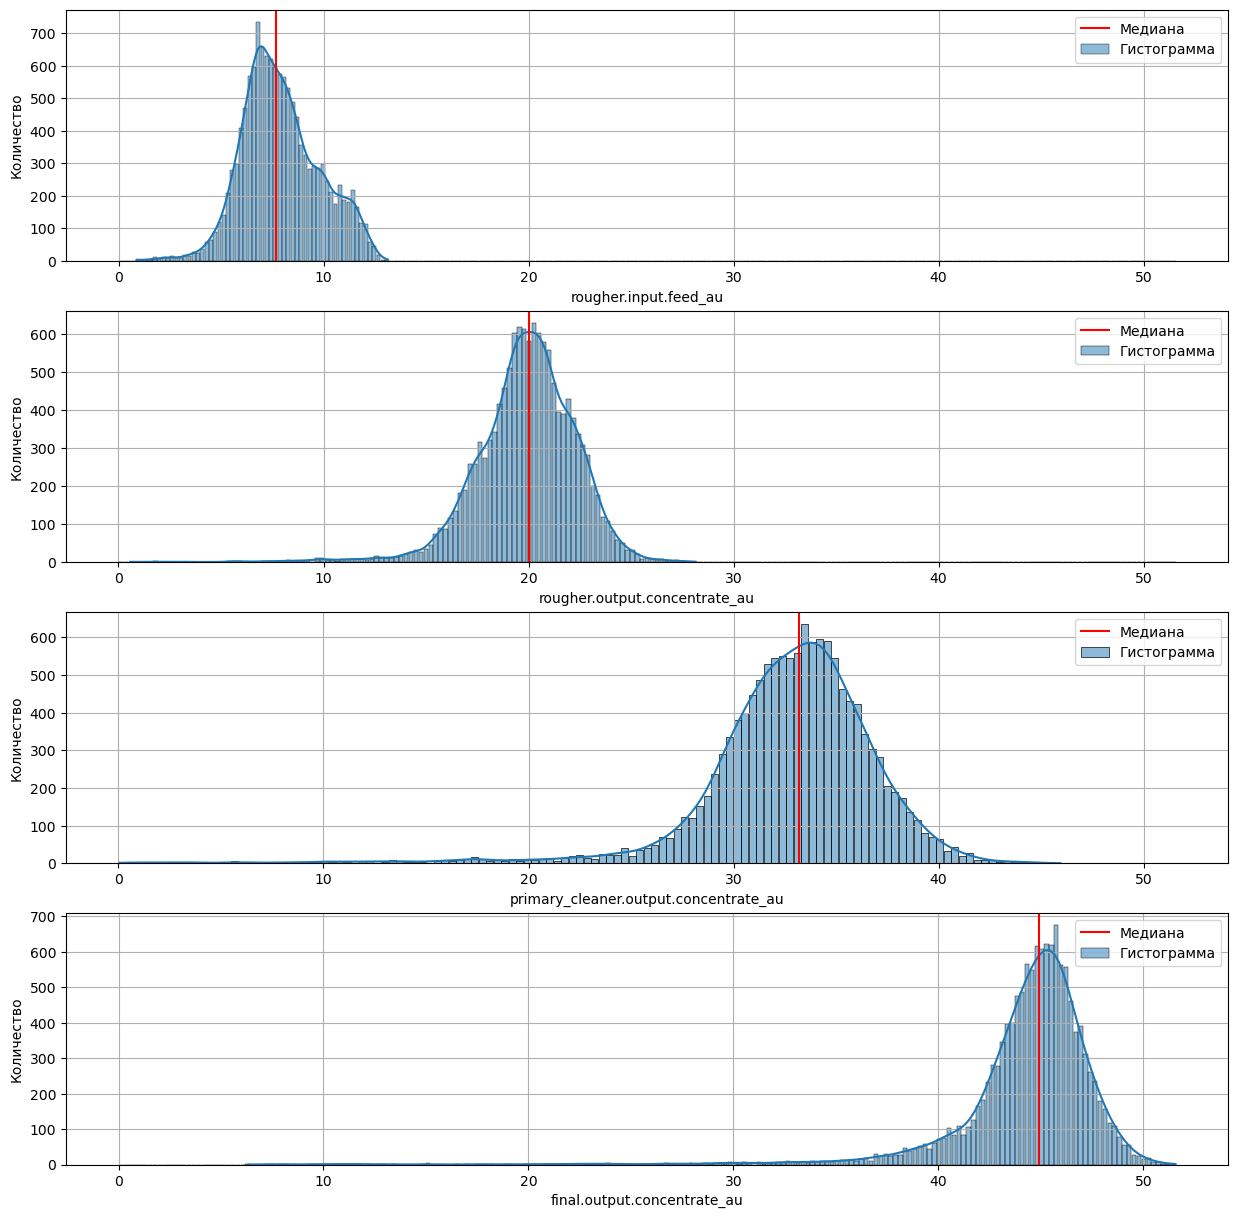

In [22]:
show_hist(concent_au)

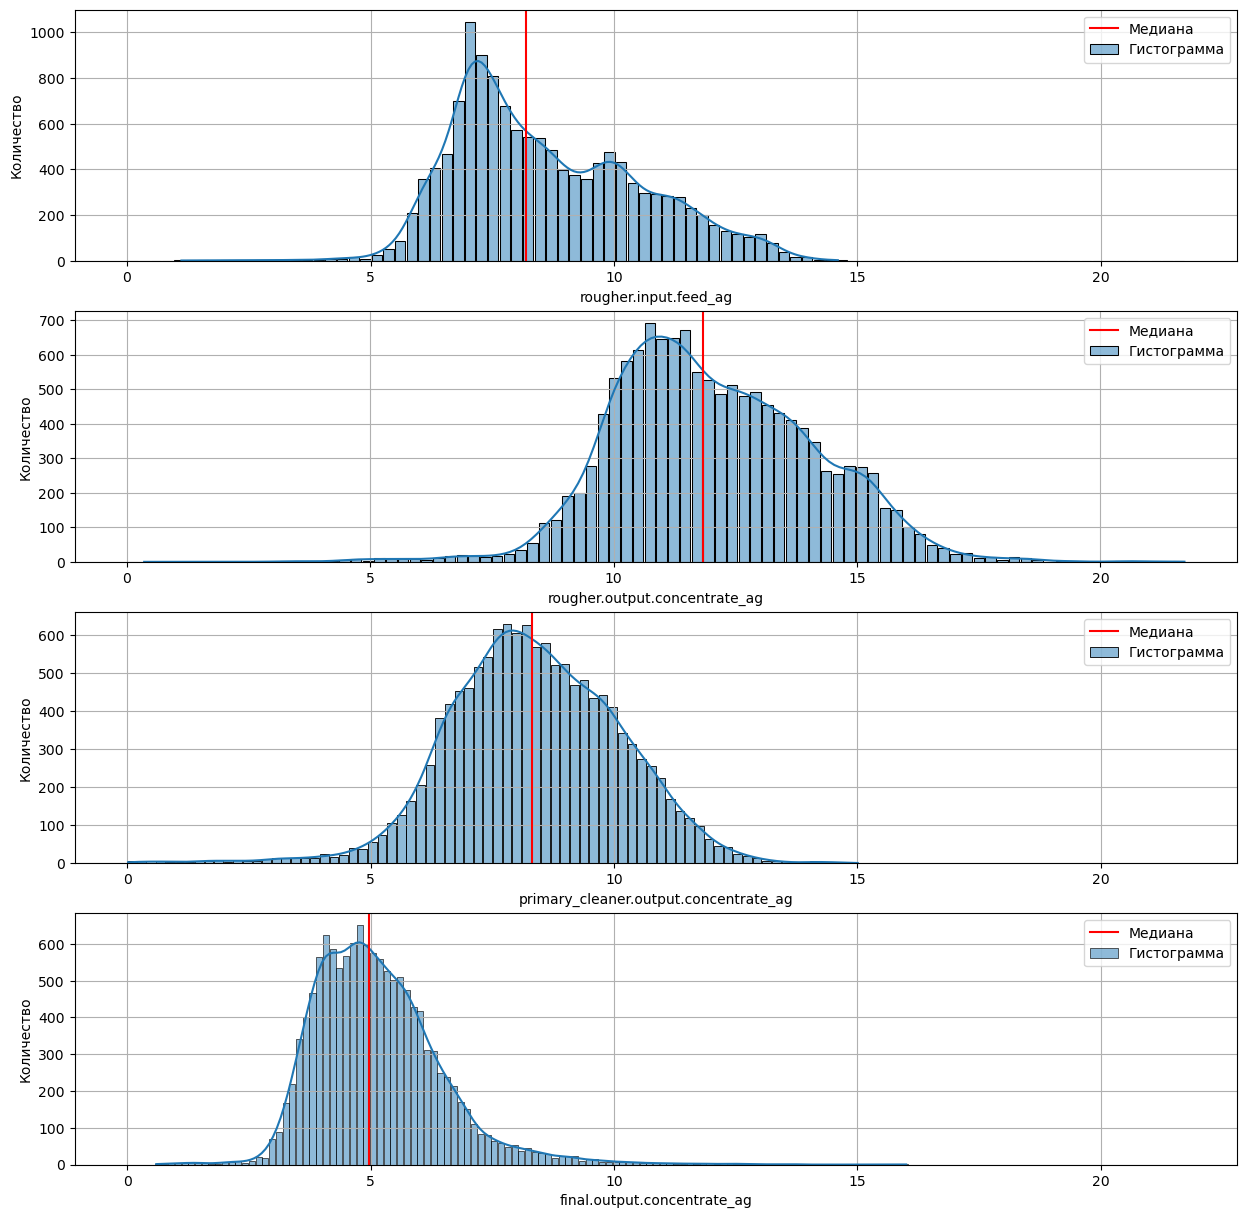

In [23]:
show_hist(concent_ag)

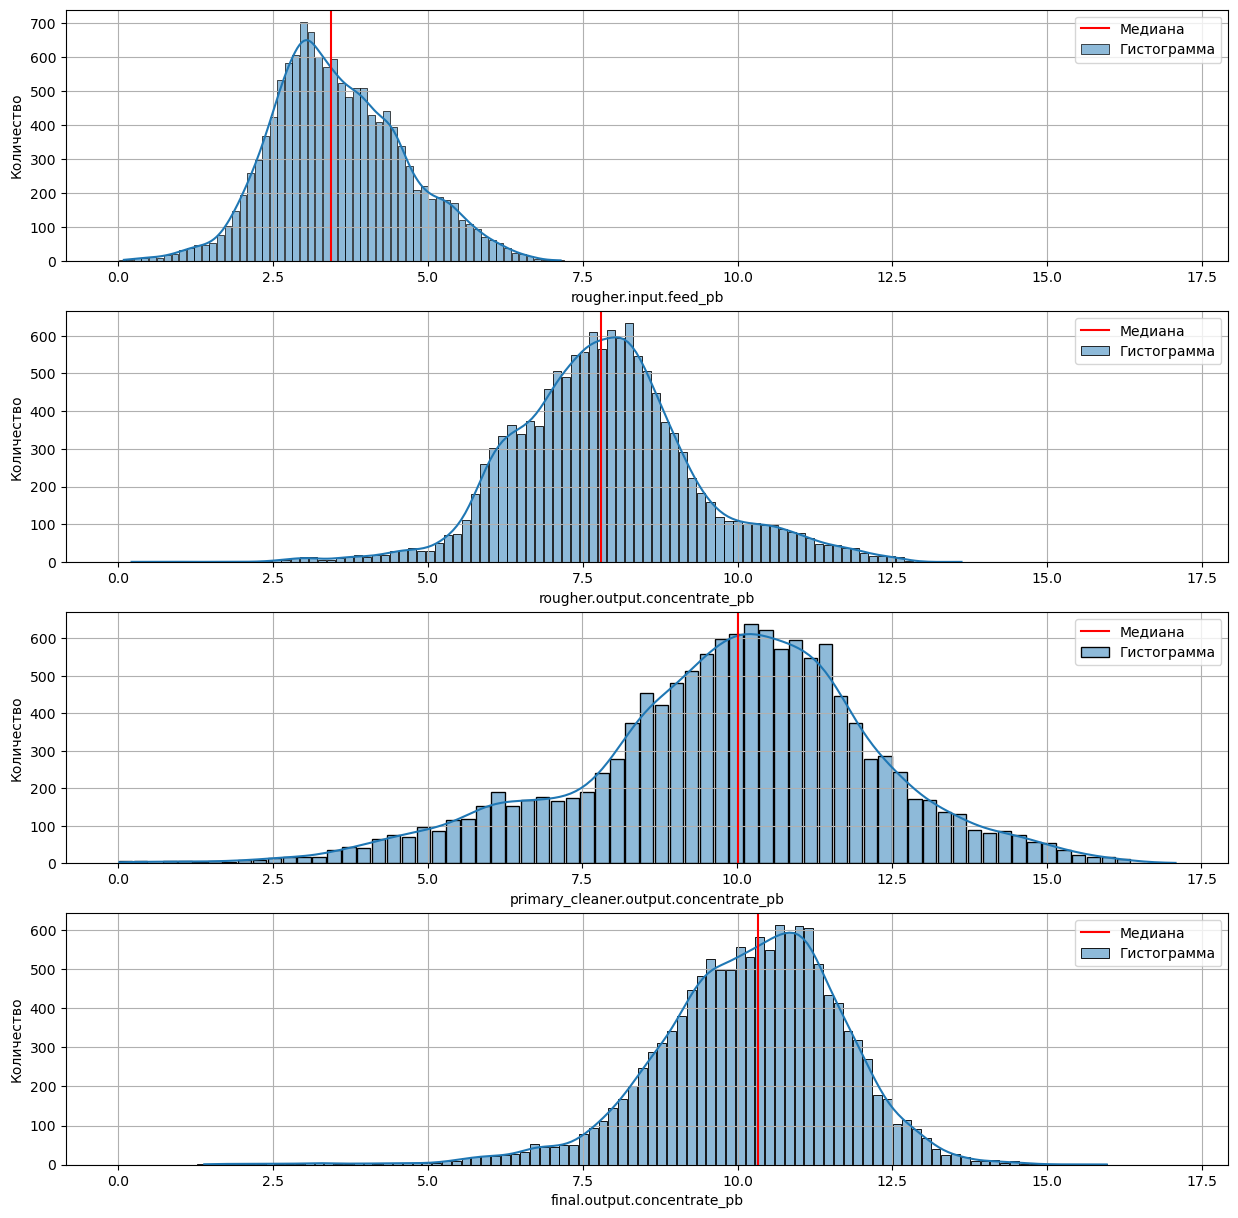

In [24]:
show_hist(concent_pb)

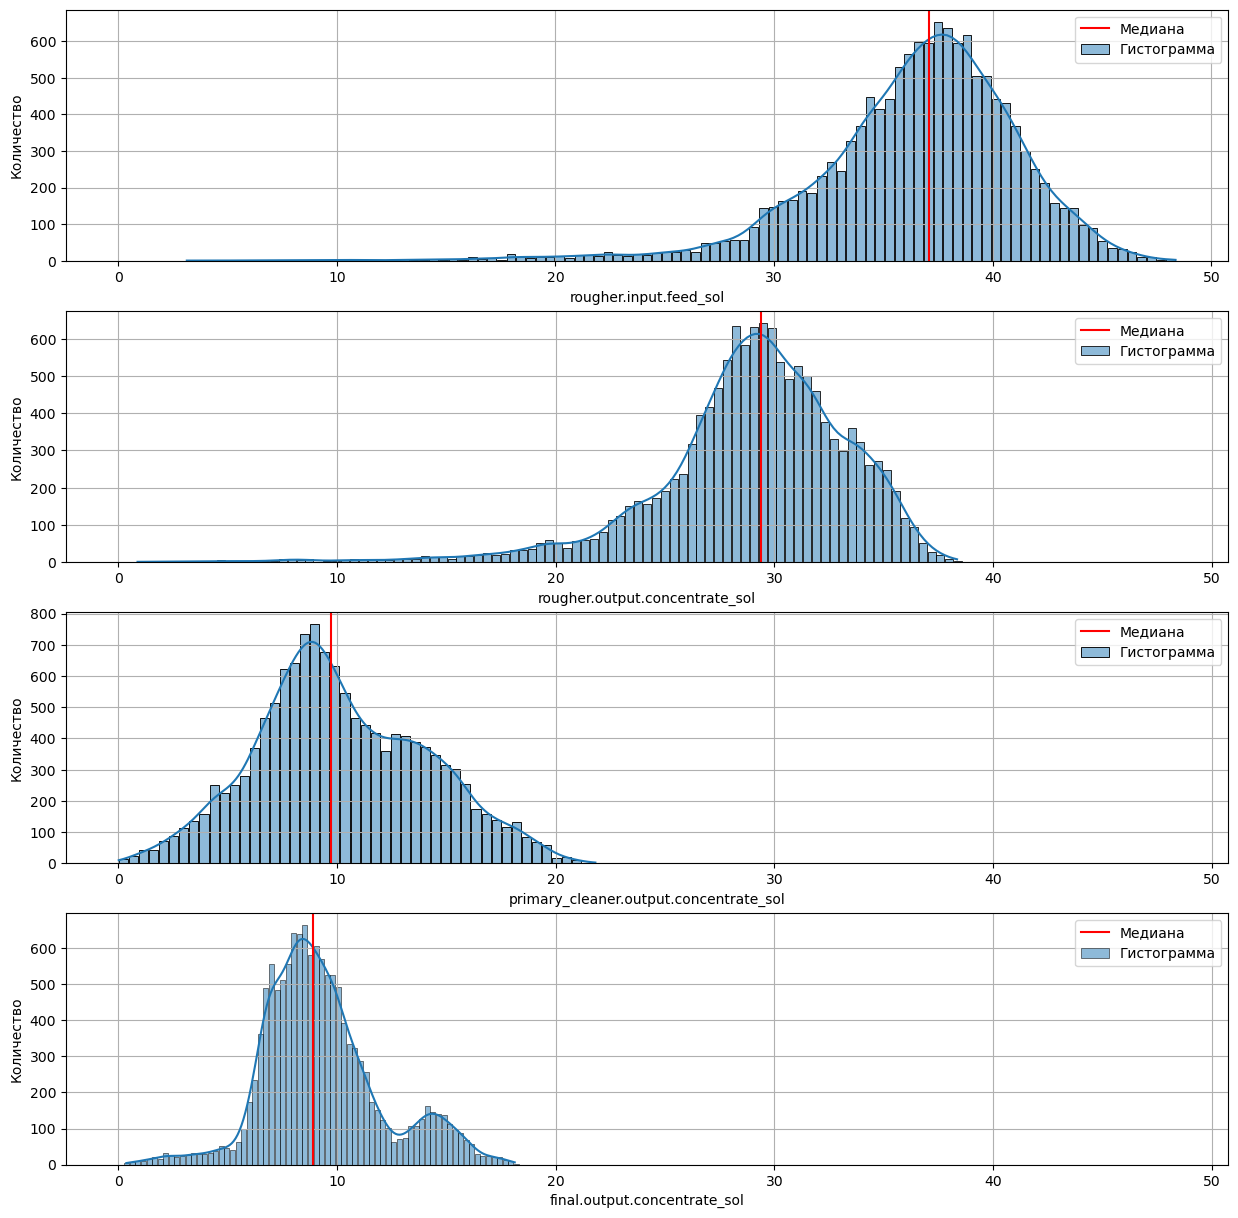

In [25]:
show_hist(concent_sol)

* концентрация золота увеличивается от этапа к этапу.
* концентрация свинца также увеличивается, но не так интенсивно.
* также стоит отметить, что после флотации растет и концентрация серебра, в дальнейшем его концентрация падает. Флотационный реагент взаимодействует с близкими между собой по свойствам металлами (метод работает, кто бы сомневался).
* Концентрация остальных веществ падает на всех этапах.
* Наблюдаются выбросы в 0, скорее всего связанные с ошибками в замерах.

### Посмотрим на распределения размеров гранул в обучающей и тестовой выборке.

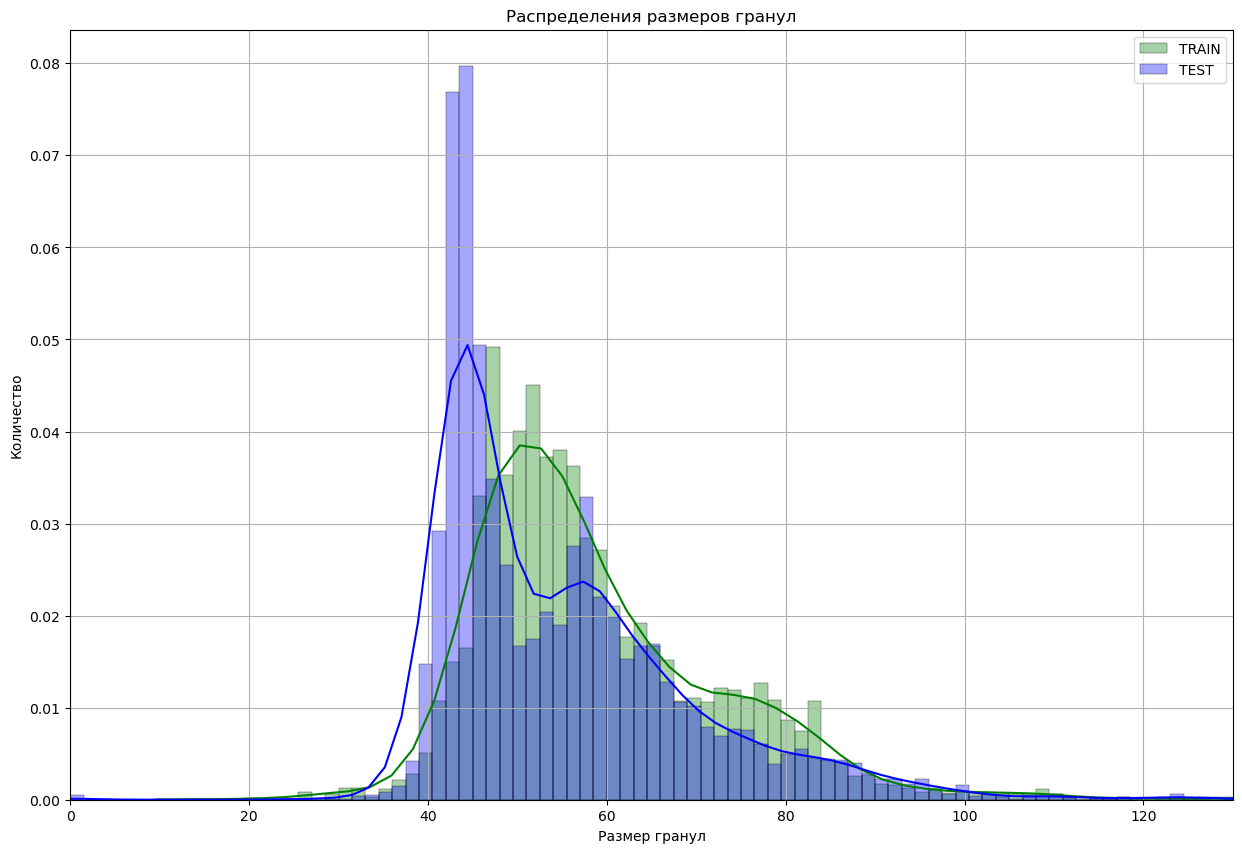

In [26]:
fig, ax = plt.subplots(1, 1,figsize=(15,10))
sns.histplot(train['rougher.input.feed_size'],
                color='green', 
                bins=100, 
                binrange=(0,150), 
                ax=ax, 
                alpha=0.35, label='TRAIN',
                kde=True,
                stat='density'
           )
sns.histplot(test['rougher.input.feed_size'], 
                 color='blue', 
                 bins=100, 
                 binrange=(0,150),
                 ax=ax, 
                 alpha=0.35, label='TEST', 
                 kde=True,
                 stat='density'
            )
ax.set_title('Распределения размеров гранул')
ax.set_xlabel('Размер гранул')
ax.set_ylabel('Количество')
ax.set_xlim([0,130])
ax.grid()
ax.legend()


* По гистограмме видно, что вид распределения размеров гранул в тестовой и обучающей выборке примерно одинаковый.

### Посмотрим на суммарную концентрацию металлов

In [27]:
sum_concentrate = pd.DataFrame()
for i, stage in zip(range(4), ['Флорация', 
                               'Черновой концентрат', 
                               'Концентрат после первой очистки',
                               'Финальный концентрат']):
    sum_concentrate[stage] = \
concent_au[concent_au.columns[i]]+\
concent_ag[concent_ag.columns[i]]+\
concent_pb[concent_pb.columns[i]]+\
concent_sol[concent_sol.columns[i]]
sum_concentrate

,Флорация,Черновой концентрат,Концентрат после первой очистки,Финальный концентрат
date,,,,
2016-01-15 00:00:00,51.680034,66.424950,72.640924,63.644396
2016-01-15 01:00:00,50.659114,67.012710,72.543485,63.957723
2016-01-15 02:00:00,50.609929,66.103793,72.095042,64.311180
2016-01-15 03:00:00,51.061546,65.752751,59.957723,63.573449
2016-01-15 04:00:00,47.859163,65.908382,71.321010,64.004667
...,...,...,...,...
2018-08-18 06:59:59,53.415050,70.781325,59.001692,68.098589
2018-08-18 07:59:59,53.696482,70.539603,59.703912,68.274362
2018-08-18 08:59:59,54.589604,55.376330,59.561096,68.226068


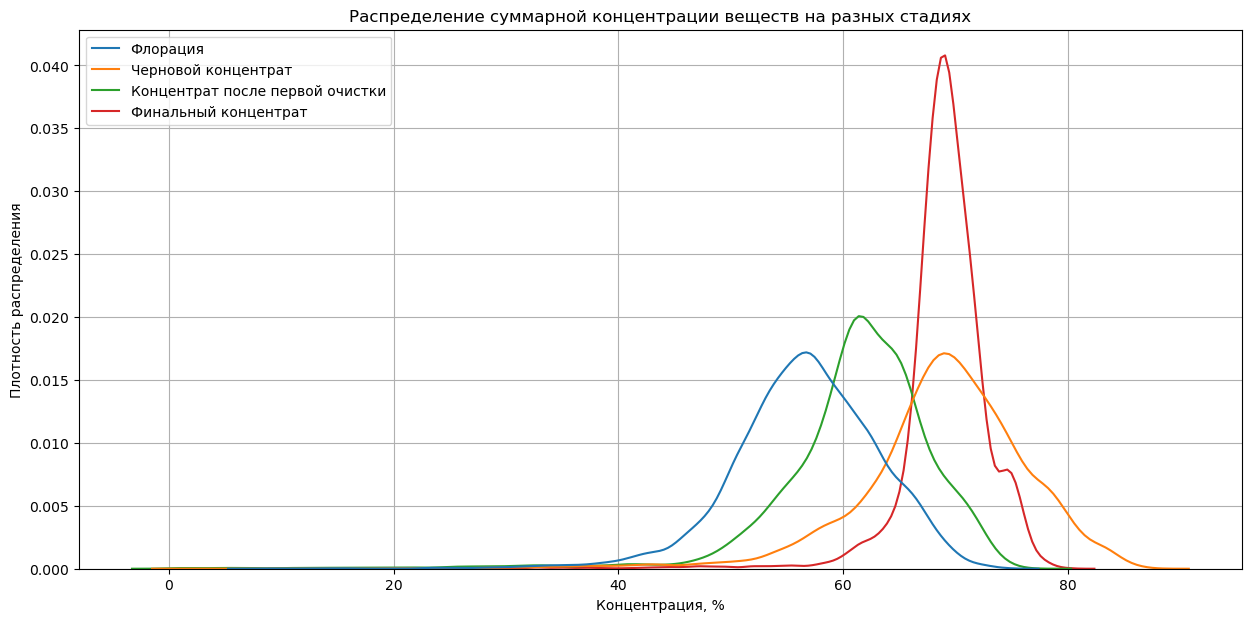

In [28]:
fig, ax = plt.subplots(figsize=(15,7))
sns.kdeplot(data = sum_concentrate, ax=ax)
ax.set_title('Распределение суммарной концентрации веществ на разных стадиях')
ax.set_xlabel('Концентрация, %')
ax.set_ylabel('Плотность распределения')
ax.grid()

* Суммарная концентрация веществ на выходе больше, чем на входе.
* Медианы суммарной концентрация веществ после флотации и на выходе примерно совпадают.
* Разброс суммарной концентрации после финальной стадии существенно меньше чем после флотации, а значит концентрация на выходе более стабильна.

## Модель

### Функции метрик и поиска лучших параметров.

In [29]:
def smape (y, y_pred):
    return np.mean(np.abs(y - y_pred) * 100 / ((np.abs(y) + np.abs(y_pred)) / 2))

In [30]:
def smape_total (smape_rougher, mape_final):
    return 0.25 * smape_rougher + 0.75 * smape_final

In [31]:
sMAPE = make_scorer(smape, greater_is_better=False)

In [32]:
def best_params(algo, X, y, space, other_params):
    def score(params):
        loss = cross_val_score(algo(**params, **other_params), 
                            X=X, 
                            y=y, 
                            scoring=sMAPE,
                            cv=KFold(n_splits=3, shuffle=True), 
                            #n_jobs=-1
                           )

        result = {'loss': abs(loss.mean()), 'status': STATUS_OK}
        print(f'средний sMAPE: {abs(loss.mean()):.4f}    sMAPE: {abs(loss)}')
        return result

    trials = Trials()

    best_params = fmin(score, space = space, algo=tpe.suggest, trials=trials, max_evals=5)
    print ('Лучшие гиперпараметры:', best_params)
    return best_params

In [33]:
# def corr_features(X, thresh):
#     cor = X.corr()
#     c1 = cor.stack().sort_values(ascending=False).drop_duplicates()
#     all_cor = c1[c1.values != 1]
#     return all_cor[abs(all_cor) > thresh]

### Этап 1. Прогноз эффективности флотации.

#### Формируем признаки и целевую переменную

In [34]:
X_train_rougher = train_not_nan[[x for x in train_drop_diff.columns if 'rougher' in x]]
y_train_rougher = train['rougher.output.recovery']

In [35]:
# y_train_rougher = y_train_rougher[y_train_rougher!=0]
# X_train_rougher = X_train_rougher.loc[y_train_rougher.index]

In [36]:
X_test_rougher = test_not_nan[[x for x in train_drop_diff.columns if 'rougher' in x]]
y_test_rougher = full['rougher.output.recovery'].loc[test.index]

In [37]:
# y_test_rougher = y_test_rougher[y_test_rougher!=0]
# X_test_rougher = X_test_rougher.loc[y_test_rougher.index]

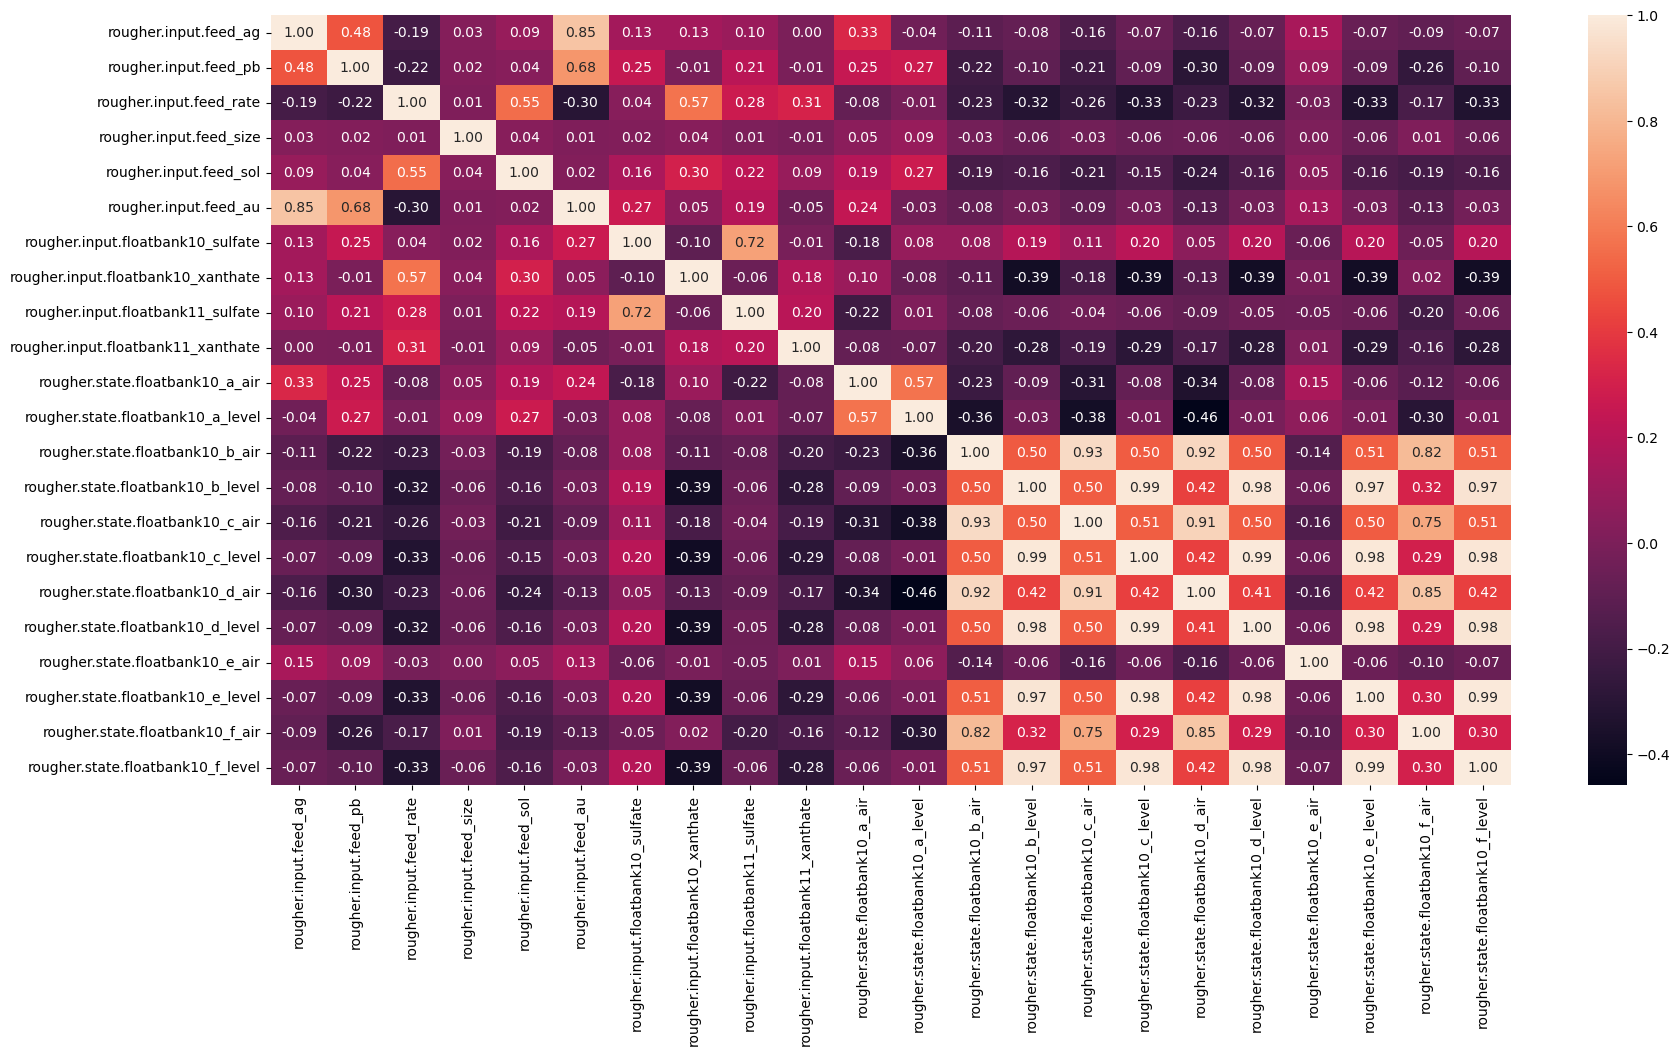

In [38]:
fig, ax = plt.subplots(figsize=(20,10))
corr_matrix = X_train_rougher.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", ax=ax);

#### Выбор модели

**Catboost**

In [39]:
# best_params_cbr = best_params(CatBoostRegressor, X_train_rougher, y_train_rougher,
#                               space={
#                                   'max_depth' : scope.int(hp.quniform('max_depth', 6, 12, 2)),
#                                   'n_estimators' : scope.int(hp.quniform('n_estimators', 600, 1400, 200))
#                         },
#                 other_params = {'silent':True,
#                                 'learning_rate': 0.01, 
#                                 #'n_estimators' : 1000
#                                }
#                              )

**Randomforrest**

In [40]:
# best_params_rfr = best_params(RandomForestRegressor, 
#                               X_train_rougher, 
#                               y_train_rougher,
#                               space = {
#                                   'max_depth' : scope.int(hp.quniform('max_depth', 6, 12, 2)),
#                                   'n_estimators' : scope.int(hp.quniform('n_estimators', 600, 1400, 200))
#                               },
#                               other_params = {
#                                }
#                              )


**Catboost показывает лучшие значения SMAPE**

#### Обучение модели с лучшими параметрами

In [41]:
best_params_cbr = {'max_depth': 10, 'n_estimators': 800}

In [42]:
cbr_best = CatBoostRegressor(**best_params_cbr, eval_metric='SMAPE')

In [43]:
cbr_best.fit(X_train_rougher, y_train_rougher, plot=True, silent=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

#### Оценка важности признаков

auto_size_plot=False is deprecated and is now ignored! Use plot_size=None instead.


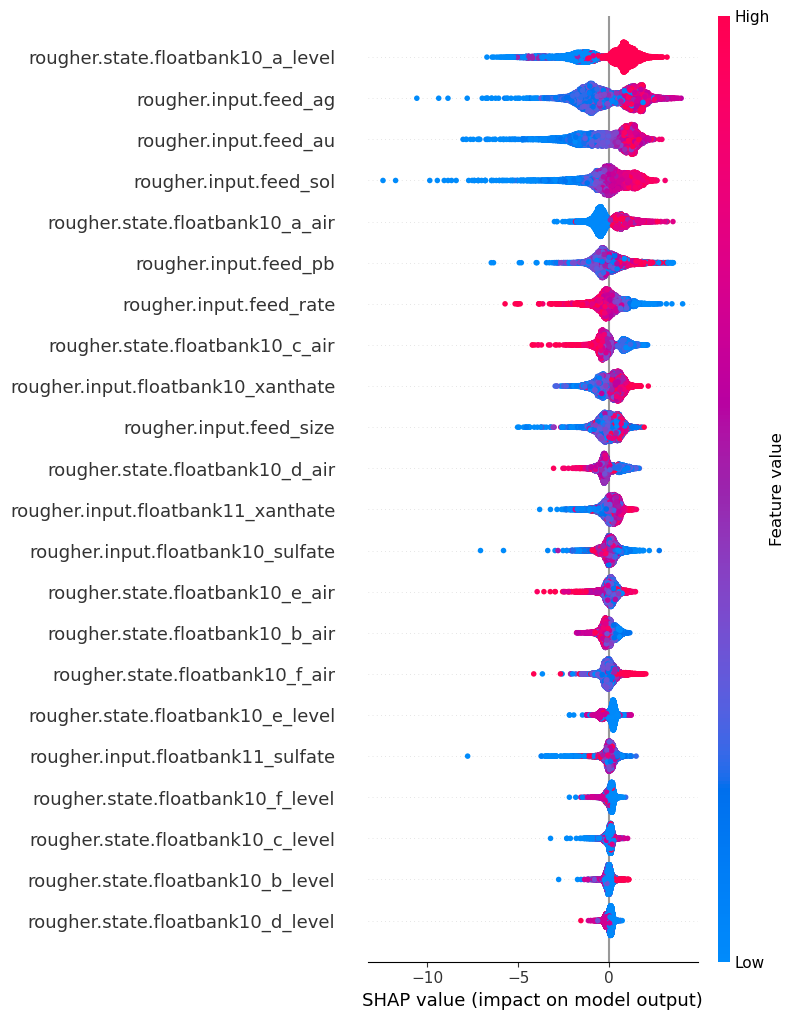

In [44]:
shap_values = shap.TreeExplainer(cbr_best).shap_values(X_train_rougher)
shap.summary_plot(shap_values , X_train_rougher, max_display=25, auto_size_plot=True)

In [45]:
pd.DataFrame(cbr_best.feature_importances_, cbr_best.feature_names_, columns = ['Важность']).sort_values(by='Важность', ascending=False).style.bar()

,Важность
rougher.input.feed_ag,12.955178
rougher.state.floatbank10_a_level,9.806476
rougher.input.feed_sol,7.034953
rougher.input.feed_size,7.030164
rougher.input.feed_pb,6.797180
rougher.state.floatbank10_a_air,6.267461
rougher.input.feed_au,5.762799
rougher.input.floatbank10_xanthate,5.016186
rougher.input.floatbank11_xanthate,4.137530
rougher.input.feed_rate,4.030121


По показателям важности признаков, а также суммарной диаграмме значений Шепли:
* Сильное положительное влияние на эффективность оказывает концентрация ценных металлов в исходной руде (причем не только золота), но эти параметры напрямую не связанны с нашим техпроцессом.
* Также существенное положительное влияние на эффективность оказывает увеличение подачи воздуха, флотационного реагента, а также уровеня жидкости в первой камере флотационной установки.

In [46]:
c_median = train['rougher.output.concentrate_au'].median()
t_median = train['rougher.output.tail_au'].median()
f_max= train['rougher.input.feed_ag'].max()

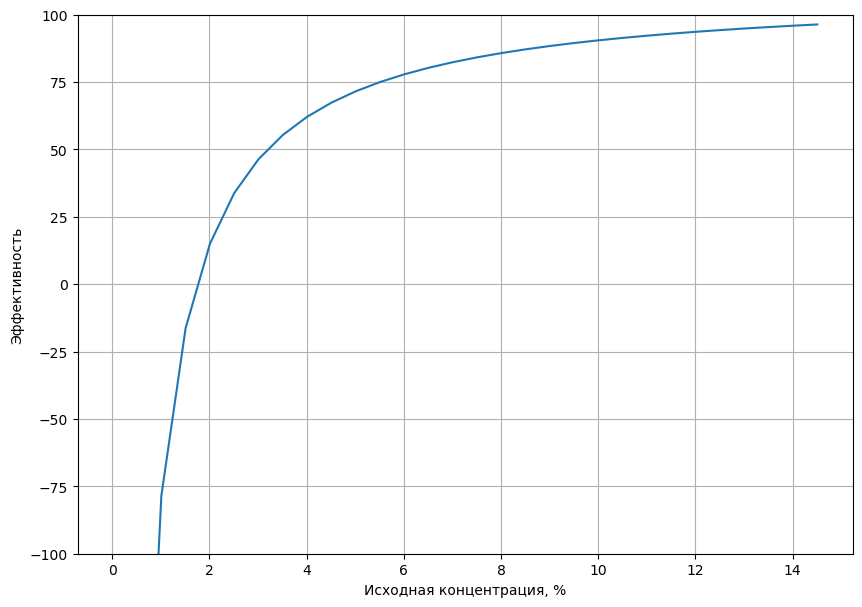

In [47]:
fig, ax = plt.subplots(figsize=(10,7))
f = np.arange(0.01, f_max, 0.5)
#c = np.arange(2, 100, 0.01)

plt.plot(f, ((c_median*(f-t_median)) / (f*(c_median-t_median)))*100)
#plt.plot(c, ((c*(f_median-t_median)) / (f_median*(c-t_median)))*100)

ax.set_xlabel('Исходная концентрация, %')
ax.set_ylabel('Эффективность')
ax.set_ylim([-100, 100])
ax.grid()

#### Предсказание эффективности и расчет SMAPE для этапа флотации

In [48]:
y_pred_rougher = cbr_best.predict(X_test_rougher)
smape_rougher = smape(y_test_rougher, y_pred_rougher)
print (f'SMAPE флотации: {smape_rougher:.3f} %')

SMAPE флотации: 3.943 %


#### Проверка выбранной модели на адекватность

In [49]:
dr_rougher = DummyRegressor()
dr_rougher.fit(X_train_rougher, y_train_rougher)
print (f'SMAPE фиктивного регрессора: {smape(y_test_rougher, dr_rougher.predict(X_test_rougher)):.3f} %')

SMAPE фиктивного регрессора: 4.995 %


* Тест пройден

### Этап 2. Прогноз эффективности всего техпроцесса.

#### Формируем признаки и целевую переменную

In [50]:
X_train_final = train_not_nan
y_train_final = train['final.output.recovery']

In [51]:
# y_train_final = y_train_final [y_train_final!=0]
# X_train_final  = X_train_final .loc[y_train_final.index]

In [52]:
X_test_final = test_not_nan
y_test_final = full['final.output.recovery'].loc[test.index]

In [53]:
# y_test_final = y_test_final[y_test_final!=0]
# X_test_final = X_test_final.loc[y_test_final.index]

#### Выбор модели

*Примечание:* Зафиксировал найденные гиперпараметры, и закомментил подбор, чтобы не пересчитывать.

**Catboost**

In [54]:
# best_params_cbrtest_not_nanl = best_params(CatBoostRegressor, X_train_final, y_train_final,
#                 space = {'max_depth' : hp.quniform('max_depth', 6, 12, 2),
#                          'n_estimators' : scope.int(hp.quniform('n_estimators', 600, 1400, 200))
#                         },
#                 other_params = {'silent':True,
#                                 'learning_rate': 0.01
#                                }
#                              )

**RandomForrest**

In [55]:
# best_params_rfr_final = best_params(RandomForestRegressor, 
#                               X_train_final, 
#                               y_train_final,
#                               space = {
#                                   'max_depth' : scope.int(hp.quniform('max_depth', 6, 12, 2)),
#                                   'n_estimators' : scope.int(hp.quniform('n_estimators', 600, 1400, 200))
#                               },
#                               other_params = {
#                                }
#                              )

**Catboost показывает лучшие значения SMAPE**

#### Обучение модели с лучшими параметрами

In [56]:
best_params_cbr_final = {'max_depth': 10,  'n_estimators': 1200}

In [57]:
cbr_best_final = CatBoostRegressor(**best_params_cbr_final, 
                                   eval_metric='SMAPE')

In [58]:
cbr_best_final.fit(X_train_final, y_train_final, plot=True, silent=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

#### Оценка важности признаков

auto_size_plot=False is deprecated and is now ignored! Use plot_size=None instead.


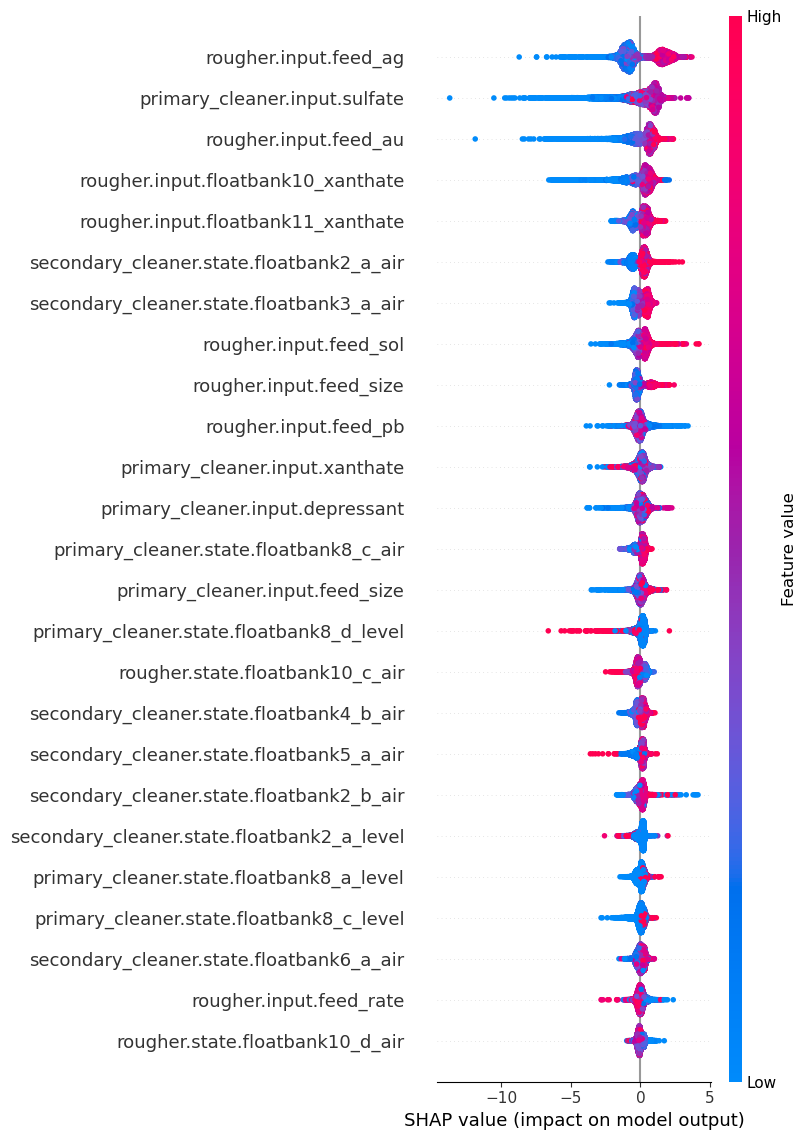

In [59]:
shap_values_final = shap.TreeExplainer(cbr_best_final).shap_values(X_train_final)
shap.summary_plot(shap_values_final, X_train_final, max_display=25, auto_size_plot=True)

In [60]:
pd.DataFrame(cbr_best_final.feature_importances_, cbr_best_final.feature_names_, columns = ['Важность']).sort_values(by='Важность', ascending=False).style.bar()

,Важность
primary_cleaner.input.sulfate,7.624512
rougher.input.feed_ag,7.250721
rougher.input.floatbank10_xanthate,4.736018
rougher.input.feed_au,3.765188
primary_cleaner.input.xanthate,3.583360
rougher.input.feed_pb,3.243399
secondary_cleaner.state.floatbank2_a_air,3.073129
primary_cleaner.input.feed_size,2.976511
primary_cleaner.input.depressant,2.727322
rougher.input.feed_sol,2.724143


#### Предсказание эффективности и расчет SMAPE для всего техпроцесса.

In [61]:
y_pred_final = cbr_best_final.predict(X_test_final)
smape_final = smape(y_test_final, y_pred_final)
print (f'SMAPE техпроцесса: {smape_final:.3f} %')

SMAPE техпроцесса: 7.781 %


#### Проверка выбранной на адекватность

In [62]:
dr_final = DummyRegressor()
dr_rougher.fit(X_train_final, y_train_final)
print (f'SMAPE фиктивного регрессора: {smape(y_test_final, dr_rougher.predict(X_test_final)):.3f} %')

SMAPE фиктивного регрессора: 8.043 %


* Тест пройден

### Итоговая SMAPE и выводы.

In [63]:
print(f'Итоговая SMAPE: {smape_total(smape_rougher, smape_final):.3f} %')

Итоговая SMAPE: 6.821 %


* Из анализа данных следует, что техпроцесс действительно "заточен" на увеличение концентрации золота. При этом также растет концентрация свинца, но не так быстро. 
* Для обоих этапов расчета была выбрана модель на основе градиентного бустинга, но с разными гиперпараметрами.
* Модель предсказывает лучше, чем фиктивный регрессор.
* Итоговая ошибка ~6.8%
* Модель также предсказывает, что увеличение количества реагентов, подачи воздуха и уровня жидкости в камере положительно сказывается на итоговую метрику. НО вносить изменения в техпроцесс с целью его оптимизации следует очень аккуратно и с сопоставлением с физической и химической моделями процесса, а не только на основании статистических данных.